In [1]:

#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import numpy.matlib as mat
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pylab as pl


In [2]:
# parameters for viral dynamics model
aS  = 350    # constant growth rate of suseceptible cells
dS  = 0.3    # death rate of suseceptible cells
Bt0 = 1e-4   # infection rate of T-cells
dA  = 1      # death rate of infected cells
pi  = 1e3    # burst rate of virus from cells
gam = 18     # virus clearance rate

n=pi/gam

In [12]:
#stochastic differential equation simulation
def sde_simulate(X0,t,num):
        
    Y=[]; Y_all=[]; X=mat.repmat(X0,num,1); dX=np.zeros([num,3]); dt=t[1]; #initialize

    for ti in t:
        Y_all.append(X); Y.append(np.mean(X,0)) #keep track of states

        N=np.random.normal(loc=0,scale=1,size=[num,3]) #3 normally distributed random numbers
        
        #using the Euler marayuma method (converges sense of Ito)
        dX[:,0] = (aS - dS*X[:,0] - Bt0*X[:,0]*X[:,2])*dt - np.sqrt(Bt0*X[:,0]*X[:,2]*dt)*N[:,0];
        dX[:,1] = (Bt0*X[:,0]*X[:,2] - dA*X[:,1])*dt + np.sqrt(Bt0*X[:,0]*X[:,2]*dt)*N[:,1];
        dX[:,2] = (pi*X[:,1] - gam*X[:,2] - Bt0*X[:,0]*X[:,2])*dt - np.sqrt(Bt0*X[:,0]*X[:,2]*dt)*N[:,2];

        X=X+dX
                    
        errors = np.where(X < 0); X[errors[0],errors[1]]=0 #correct negative numbers

#        if len(errors)>1:
#            for j in range(len(errors)):
#                X[errors[j][0],errors[j][1]]=0
#        else:
#            X[errors[0],errors[1]]=0

    return np.array(Y),np.array(Y_all)
    

In [4]:
#set of diff eqs that describes immunologic dynamics simple
def model(X,t):          
    Y=np.zeros(3); #intialize ode solution vector
    Y[0] = aS - dS*X[0] - Bt0*X[0]*X[2];
    Y[1] = Bt0*X[0]*X[2] - dA*X[1];
    Y[2] = pi*X[1] - gam*X[2];
    return Y   # for odeint

#actually simulate with scipy
def ode_simulate(X0,t):
    ode_sim = spi.odeint(model,X0,t) 
    return ode_sim

In [5]:
#initialize stochastic rate/transition matrices
num_rates=5; num_states=3; r=np.zeros(num_rates); T=np.zeros([num_rates,num_states])

#updating the rates of events
def update_rates(x,t):    
    r[0] = aS           #constant production 
    r[1] = dS*x[0]      #density dependent susceptible death
    r[2] = Bt0*x[0]*x[2] #infection
    r[3] = dA*x[1]      #infected cell burst
    r[4] = gam*x[2]      #density dependent viral clearance
    return r

#keeping track of the transitions as a matrix
def update_transition_mat(x,t):    
    T[0][0] =  1; T[0][1] =  0; T[0][2] =  0;
    T[1][0] = -1; T[1][1] =  0; T[1][2] =  0;
    T[2][0] = -1; T[2][1] =  1; T[2][2] = -1;
    T[3][0] =  0; T[3][1] = -1; T[3][2] =  np.random.poisson(pi);
    T[4][0] =  0; T[4][1] =  0; T[4][2] = -1;
    return T


In [6]:
#function that solves stochastically using tau-leap method
def tauleap_simulate(X0,t):

    dt=t[1]; x=X0; y=[] #initialize
    for ti in t:
        
        y.append(x) #the list of states
        
        r = update_rates(x,ti) #make new rate vector
        
        E = np.random.poisson(r*dt) #calculate events
        
        dx = np.sum(np.matrix.transpose(update_transition_mat(x,ti))*E,1) #calculate change in state
        
        x=x+dx #update state variable
        
        x[x<0]=0 #make sure no negative numbers
        
    return np.array(y)

In [7]:
#gillespie HIV model inspired by Keeling/Rohani+Soumpasis
change_counter = np.zeros(num_rates) #vector for gillespie algorithm to count transitions
def gillespie_simulate(X0,t_list):
    
    t=0; t_track=[0]; t_index=0; #initialize step, vectors for times and states
    
    x=X0; x_track=[X0]
   
    step=0; 
    while t < t_list[-1]:
        
        r = update_rates(x,t) #matrix of rates
        T = update_transition_mat(x,t) #matrix of transitions

        R1=pl.rand(); R2=pl.rand(); #2 uniform random numbers

        dt = -np.log(R2)/(np.sum(r)); #next time step

        t+=dt #update time
        
        m=min(pl.find(pl.cumsum(r)>=R1*pl.sum(r))); #get the index of the transition

        dx=T[m,:] #update state variable

        x=x+dx
        
        change_counter[m]+=1 #to check how many of each type happened
        
        #just keep track of times in t_list
        if t>t_list[t_index]:
            t_track.append(t)
            x_track.append(x); #append new states
            t_index+=1
    
        step+=1
    
    print('took ' + str(step) + ' iterations for gillespie algorithm')
    return np.array(t_track),np.array(x_track)


In [21]:

#parameters for simulations

S0=aS/dS; V0=0.03; I0=n*V0; #initial conditions
    
X0 = np.array([S0,I0,V0])

t=np.linspace(0,10,1e3)

num=5

#run each simulation num times
tlp_all_sol=[]
for i in range(num):
    tlp_all_sol.append(tauleap_simulate(X0,t))

#gil_t,gil_sol = gillespie_simulate(X0,t)

sde_mean_sol,sde_all_sol = sde_simulate(X0,t,num)

ode_sol = ode_simulate(X0,t)



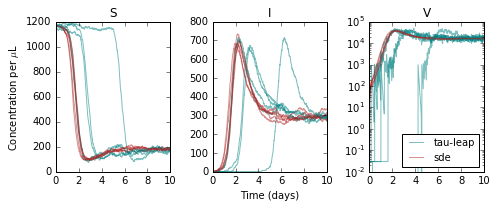

In [32]:
#plot stochastic realizations
state_names = ['S','I','V']

plt.figure(figsize=(7,3),dpi=100)
for i in range(3):
    
    plt.subplot(131+i)
    #plt.plot(t,gil_sol[:,i],lw=1,color='plum',alpha=0.5)
    for sim in range(num):
        plt.plot(t,tlp_all_sol[sim][:,i],lw=1,color='teal',alpha=0.5)
        plt.plot(t,sde_all_sol[:,sim,i],lw=1,color='firebrick',alpha=0.5)
        
        
    plt.title(state_names[i])
    #plt.xticks(np.arange(0,))
    if i==0:
        plt.ylabel('Concentration per $\mu$L')
    if i==1:
        plt.xlabel('Time (days)')

plt.legend(['tau-leap','sde'],fontsize=10,loc=4)
plt.yscale('log')
plt.tight_layout()


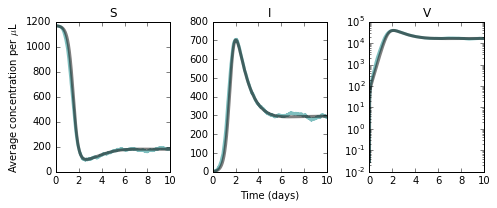

In [18]:
#plot mean solutions
plt.figure(figsize=(7,3),dpi=100)
for i in range(3):
    
    plt.subplot(131+i)
    plt.plot(t,sde_mean_sol[:,i],lw=3,color='teal',alpha=0.5)
    plt.plot(t,ode_sol[:,i],lw=3,color='k',alpha=0.5)
        
    plt.title(state_names[i])
    #plt.xticks(np.arange(0,))
    if i==0:
        plt.ylabel('Average concentration per $\mu$L')
    if i==1:
        plt.xlabel('Time (days)')

plt.yscale('log')
plt.tight_layout()
